In [84]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
import geopandas as gpd
import geodatasets




In [2]:
# Load the dataset
df = pd.read_csv("country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df.shape

(167, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

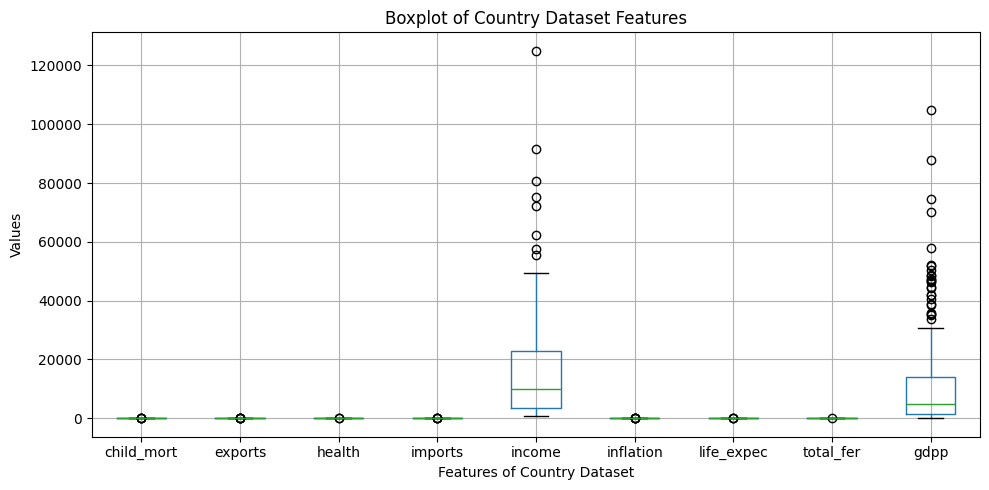

In [7]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

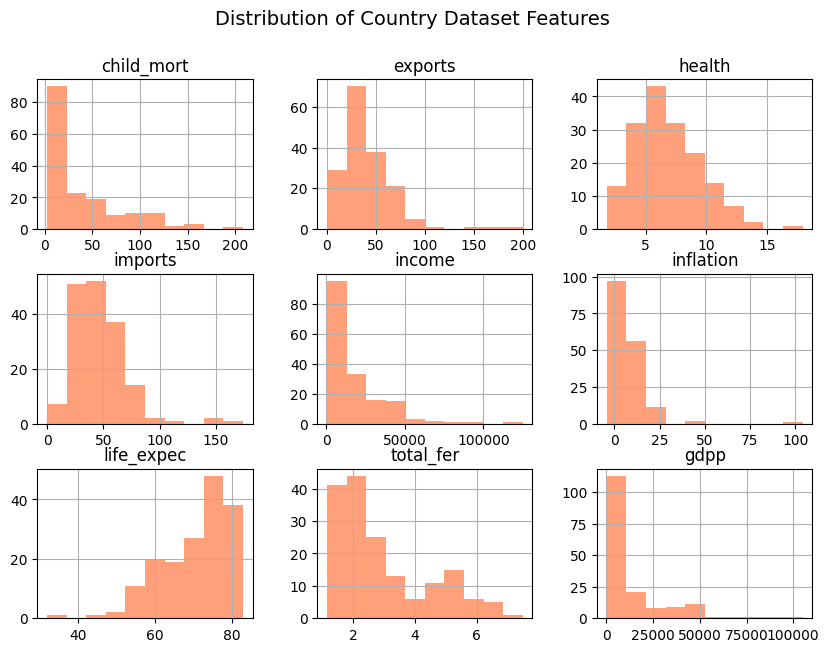

In [8]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

In [9]:
# Feature clipping right skewed features
# Define list of right skewed featutres
features = ['gdpp', 'income', 'child_mort', 'exports', 'imports', 'inflation']

# Feature clip
for feature in features:
    lower_limit, upper_limit = np.percentile(df[feature], [1,95])
    df[feature] = np.clip(df[feature], lower_limit, upper_limit)

# Feature clipping left skewed features
lower_limit, upper_limit = np.percentile(df['life_expec'], [5,100])
df['life_expec'] = np.clip(df['life_expec'], lower_limit, upper_limit)

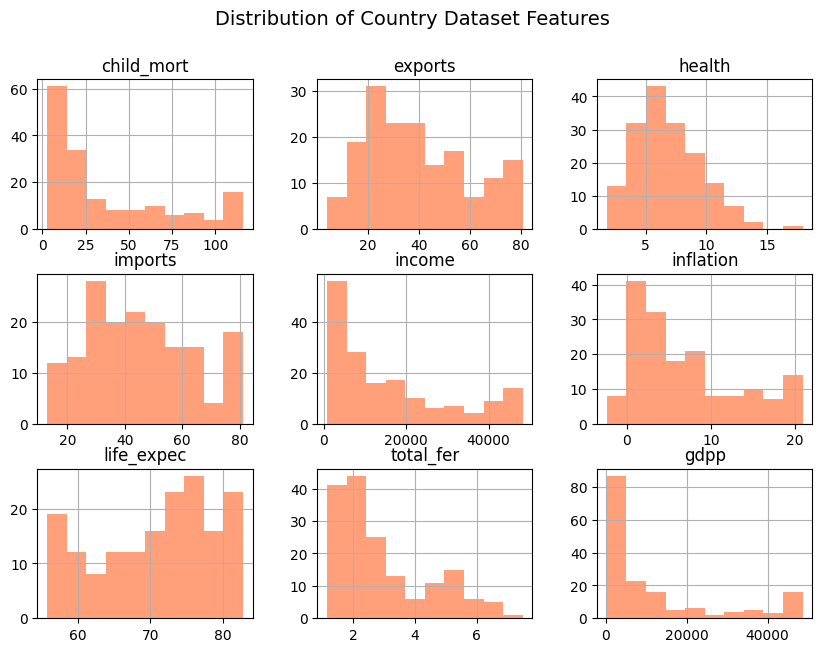

In [10]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

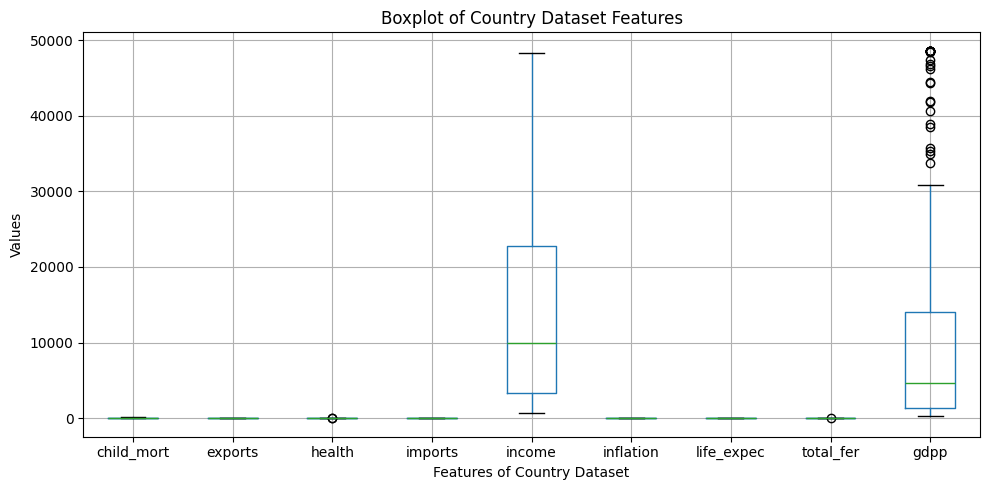

In [11]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

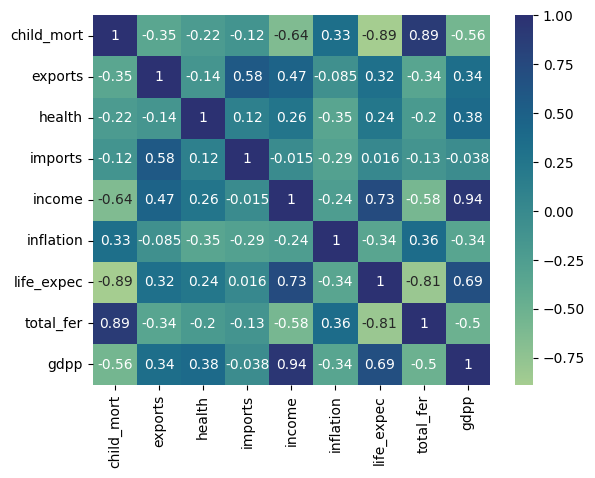

In [12]:
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')
plt.show()

In [13]:
# Scale the features
features = df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [14]:
# Finding the k value
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

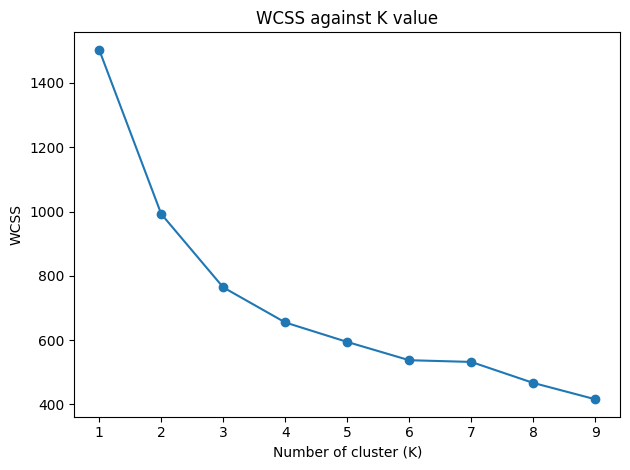

In [15]:
# plot
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of cluster (K)')
plt.ylabel('WCSS')
plt.title('WCSS against K value')
plt.tight_layout()
plt.show()

For n_clusters = 2, average silhouette score = 0.284


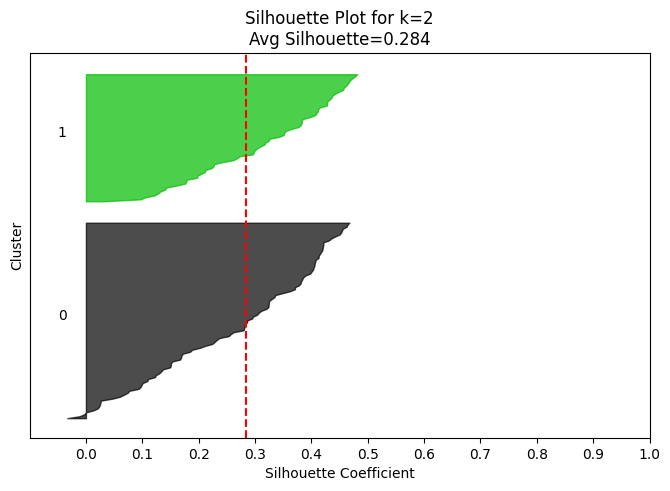

For n_clusters = 3, average silhouette score = 0.273


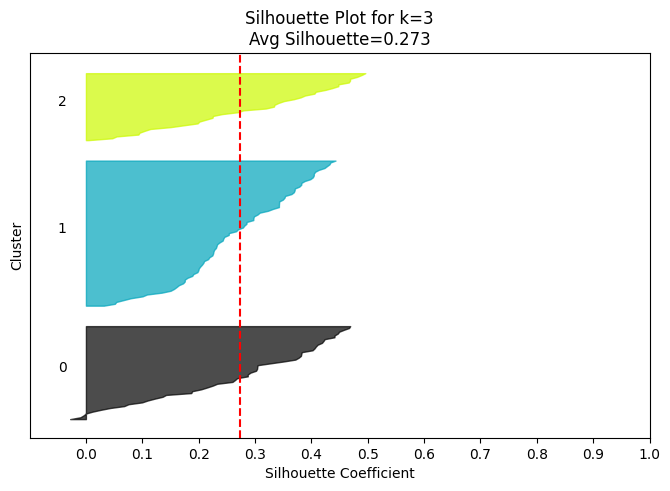

For n_clusters = 4, average silhouette score = 0.268


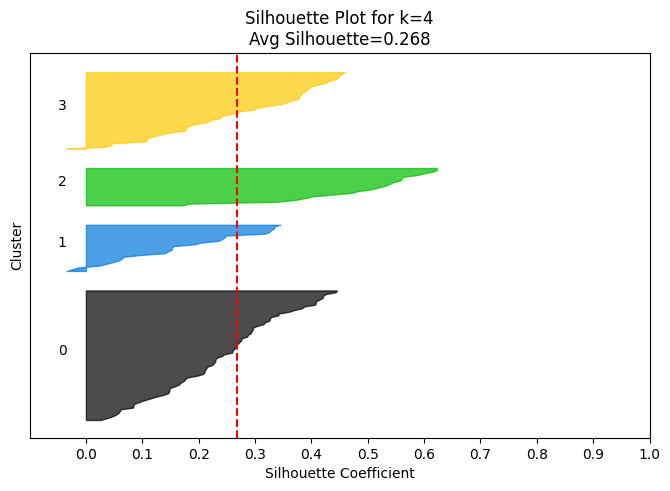

For n_clusters = 5, average silhouette score = 0.258


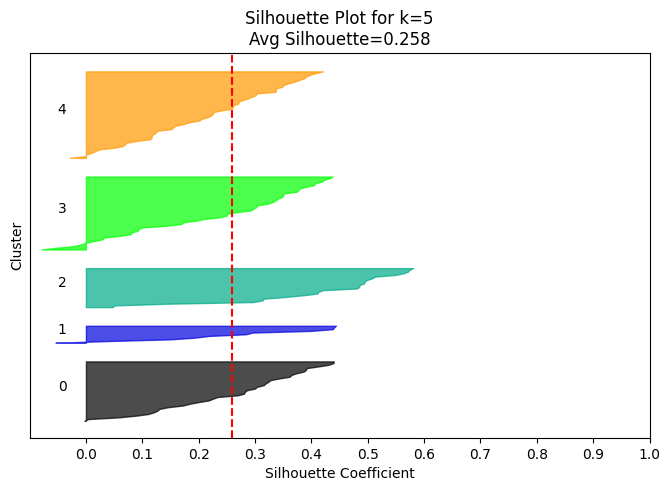

For n_clusters = 6, average silhouette score = 0.250


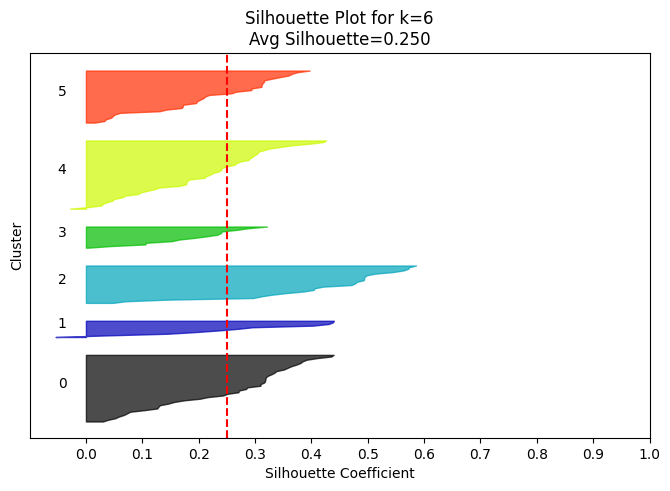

In [16]:
# Visualise Silhoutte scores to to see how well balanced they are
# Silhoutte score of closer to 1 is better

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Initialise the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_features)
    
    # Average silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)
    
    # Create a subplot for silhouette
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)
    
    # The silhouette coefficient range 
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster number at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute new y_lower for next cluster
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Visualise silhouette score for each K value
    ax1.set_title(f"Silhouette Plot for k={n_clusters}\nAvg Silhouette={silhouette_avg:.3f}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    
    # The vertical line for average silhouette score of all values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Clear the y-axis labels
    ax1.set_yticks([])  
    ax1.set_xticks([i/10 for i in range(0, 11)])
    
    plt.show()
    



In [17]:
## dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)

In [18]:
# Use the cluster to be 3
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(reduced_data)
y_predicted

array([1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1,
       0, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0,
       1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2,
       1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 0, 1, 1], dtype=int32)

In [19]:
# put the cluster into the dataframe
df['Cluster'] = y_predicted

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.20,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.30,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.50,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.10,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.80,2.13,12200.0,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.00,3.50,2970.0,1
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.40,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.10,1.95,1310.0,0
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.50,4.67,1310.0,1


In [20]:
# centroid
km.cluster_centers_

array([[ 2.43726233,  1.17067874,  0.04964944],
       [-2.03080903,  0.10163718,  0.14756218],
       [ 1.03042929, -0.63037261, -0.17640053]])

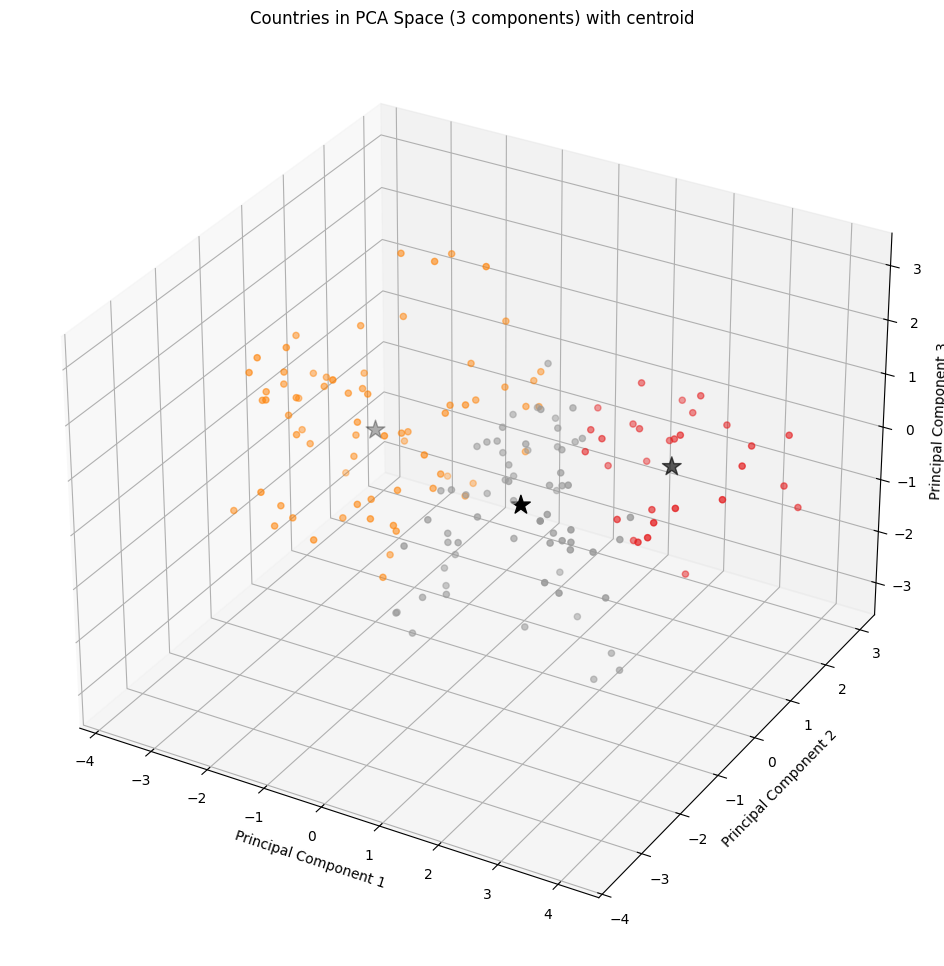

In [21]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df["Cluster"], cmap="Set1", label='Clusters')

#Plot centroids
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black', marker='*', s=200, label = 'Centroids')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components) with centroid")



plt.show()

In [22]:
# Statistics summary per cluster
numeric_cols = df.select_dtypes(include="number").columns
cluster_summary = df.groupby("Cluster")[numeric_cols].agg(["mean", "median", "min", "max"])
print(cluster_summary)

        child_mort                        exports                         \
              mean median   min    max       mean median      min    max   
Cluster                                                                    
0         7.530000   5.25   2.8   23.3  66.936333  69.75  45.5000  80.57   
1        71.512857  64.15  17.4  116.0  30.707840  25.15   3.9094  80.57   
2        13.604478  11.70   3.0   39.2  35.429851  32.70  10.7000  67.40   

           health         ... total_fer                gdpp                    \
             mean median  ...       min   max          mean   median      min   
Cluster                   ...                                                   
0        7.492000  7.185  ...      1.15  2.62  25786.666667  20900.0  1310.00   
1        6.059857  5.275  ...      2.33  7.49   2009.417714   1185.0   331.62   
2        7.302537  7.090  ...      1.27  3.66  16263.432836   8860.0  1630.00   

                 Cluster                 
             m

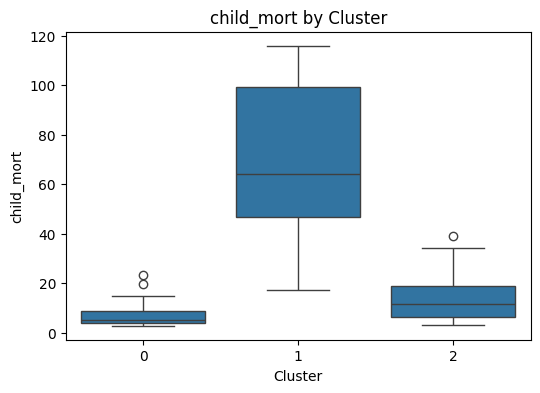

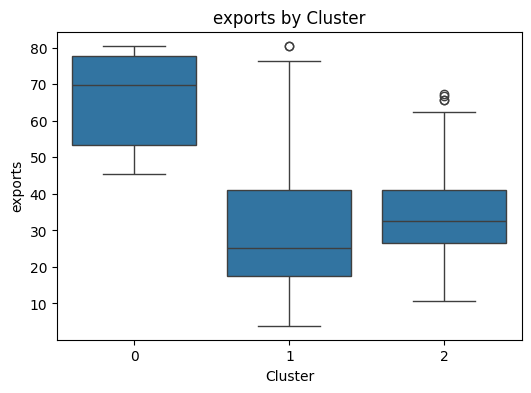

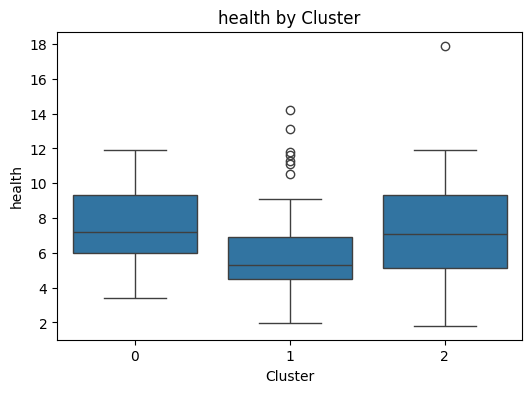

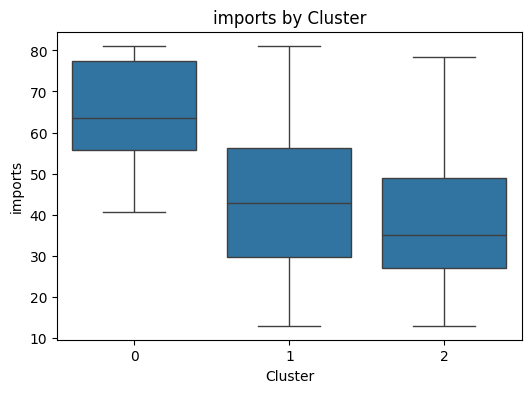

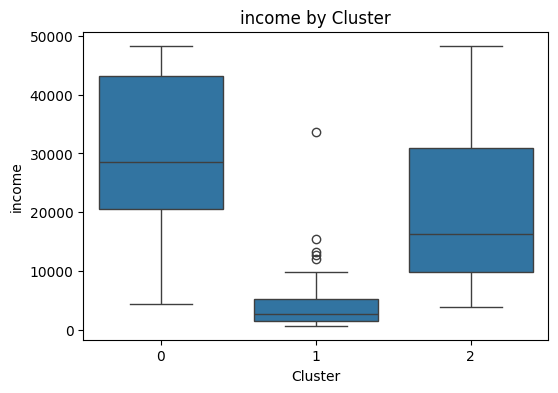

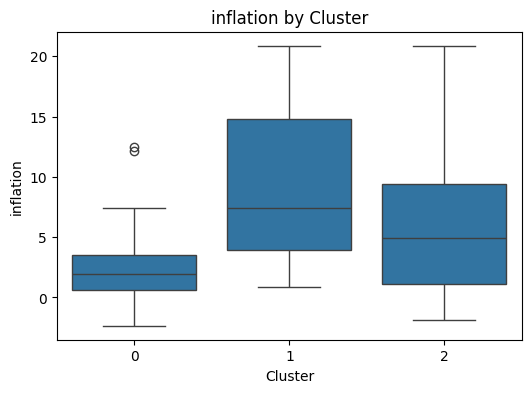

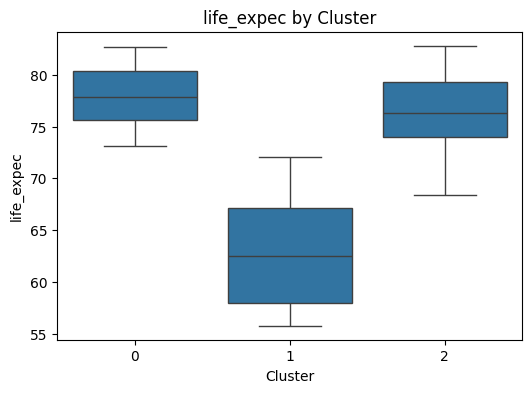

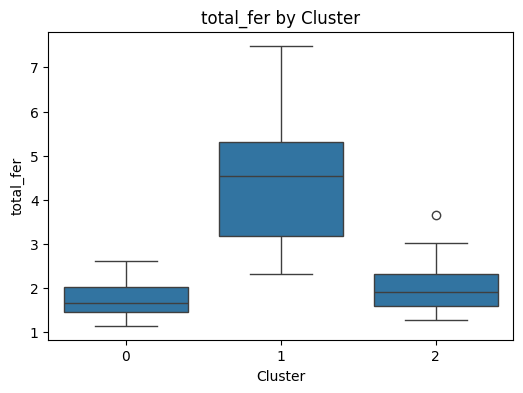

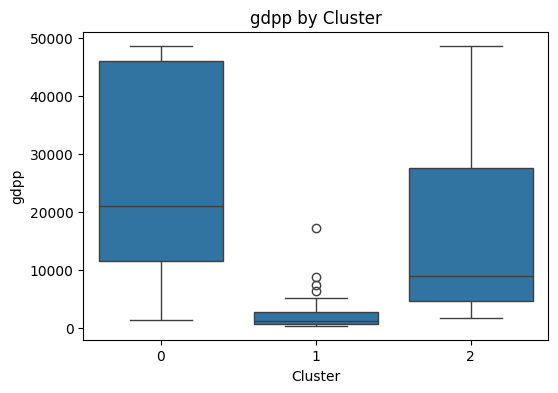

In [23]:
# Check the distribution of each Feature by cluster
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by Cluster")
    plt.show()

In [24]:
# Compare means side by side

# Extract means of each cluster
mean_values = df.groupby("Cluster")[['income', 'gdpp']].mean()
print(mean_values)
# Transpose - rows: features, columns = cluster
mean_value_transposed = mean_values.T
print(mean_value_transposed)

               income          gdpp
Cluster                            
0        30501.666667  25786.666667
1         4305.835429   2009.417714
2        21075.970149  16263.432836
Cluster             0            1             2
income   30501.666667  4305.835429  21075.970149
gdpp     25786.666667  2009.417714  16263.432836


In [25]:
# Compare means side by side

# Extract means of each cluster
mean_values2 = df.groupby("Cluster")[['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']].mean()
print(mean_values2)
# Transpose - rows: features, columns = cluster
mean_value_transposed2 = mean_values2.T
print(mean_value_transposed2)


         child_mort    exports    health    imports  inflation  life_expec  \
Cluster                                                                      
0          7.530000  66.936333  7.492000  64.623333   2.553713   77.880000   
1         71.512857  30.707840  6.059857  44.046400   9.279357   62.838857   
2         13.604478  35.429851  7.302537  37.792358   6.474060   76.105970   

         total_fer  
Cluster             
0         1.741333  
1         4.359857  
2         2.013134  
Cluster             0          1          2
child_mort   7.530000  71.512857  13.604478
exports     66.936333  30.707840  35.429851
health       7.492000   6.059857   7.302537
imports     64.623333  44.046400  37.792358
inflation    2.553713   9.279357   6.474060
life_expec  77.880000  62.838857  76.105970
total_fer    1.741333   4.359857   2.013134


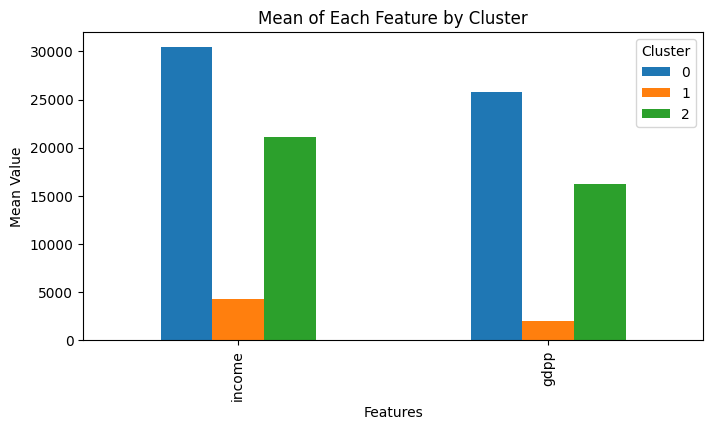

In [26]:
# plot tranposed 
mean_value_transposed.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

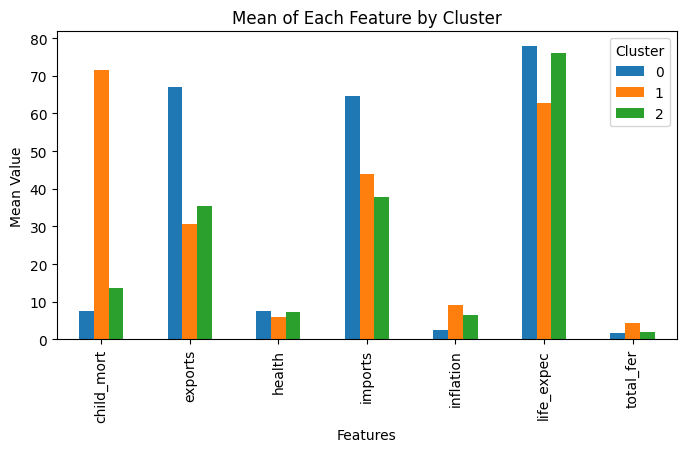

In [27]:
# plot tranposed 
mean_value_transposed2.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

In [28]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.20,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.30,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.50,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.10,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.80,2.13,12200.0,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.00,3.50,2970.0,1
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.40,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.10,1.95,1310.0,0
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.50,4.67,1310.0,1


In [73]:
# Filter countries in Cluster 1
cluster_1_countries = df[df["Cluster"] == 1]["country"]

cluster_1_countries

0      Afghanistan
3           Angola
12      Bangladesh
17           Benin
18          Bhutan
          ...     
155         Uganda
161     Uzbekistan
162        Vanuatu
165          Yemen
166         Zambia
Name: country, Length: 70, dtype: object

In [74]:
type(df)

pandas.core.frame.DataFrame

In [75]:
print(df[df["Cluster"] == 1]["country"].unique())

['Afghanistan' 'Angola' 'Bangladesh' 'Benin' 'Bhutan' 'Bolivia' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Central African Republic'
 'Chad' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire" 'Egypt'
 'Equatorial Guinea' 'Eritrea' 'Fiji' 'Gabon' 'Gambia' 'Ghana' 'Guatemala'
 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'India' 'Indonesia' 'Iraq'
 'Kenya' 'Kiribati' 'Kyrgyz Republic' 'Lao' 'Lesotho' 'Liberia'
 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Micronesia, Fed. Sts.'
 'Mongolia' 'Mozambique' 'Myanmar' 'Namibia' 'Nepal' 'Niger' 'Nigeria'
 'Pakistan' 'Philippines' 'Rwanda' 'Samoa' 'Senegal' 'Sierra Leone'
 'Solomon Islands' 'South Africa' 'Sudan' 'Tajikistan' 'Tanzania'
 'Timor-Leste' 'Togo' 'Tonga' 'Turkmenistan' 'Uganda' 'Uzbekistan'
 'Vanuatu' 'Yemen' 'Zambia']


In [78]:
# Cluster 1 df
cluster_1_df = df[df["Cluster"] == 1].reset_index(drop=True)
cluster_1_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.440,56.20,5.82,553.0,1
1,Angola,116.0,62.3,2.85,42.9,5900.0,20.870,60.10,6.16,3530.0,1
2,Bangladesh,49.4,16.0,3.52,21.8,2440.0,7.140,70.40,2.33,758.0,1
3,Benin,111.0,23.8,4.10,37.2,1820.0,0.885,61.80,5.36,758.0,1
4,Bhutan,42.7,42.5,5.20,70.7,6420.0,5.990,72.10,2.38,2180.0,1
...,...,...,...,...,...,...,...,...,...,...,...
65,Uganda,81.0,17.1,9.01,28.6,1540.0,10.600,56.80,6.15,595.0,1
66,Uzbekistan,36.3,31.7,5.81,28.5,4240.0,16.500,68.80,2.34,1380.0,1
67,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.620,63.00,3.50,2970.0,1
68,Yemen,56.3,30.0,5.18,34.4,4480.0,20.870,67.50,4.67,1310.0,1


In [79]:
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     70 non-null     object 
 1   child_mort  70 non-null     float64
 2   exports     70 non-null     float64
 3   health      70 non-null     float64
 4   imports     70 non-null     float64
 5   income      70 non-null     float64
 6   inflation   70 non-null     float64
 7   life_expec  70 non-null     float64
 8   total_fer   70 non-null     float64
 9   gdpp        70 non-null     float64
 10  Cluster     70 non-null     int32  
dtypes: float64(9), int32(1), object(1)
memory usage: 5.9+ KB


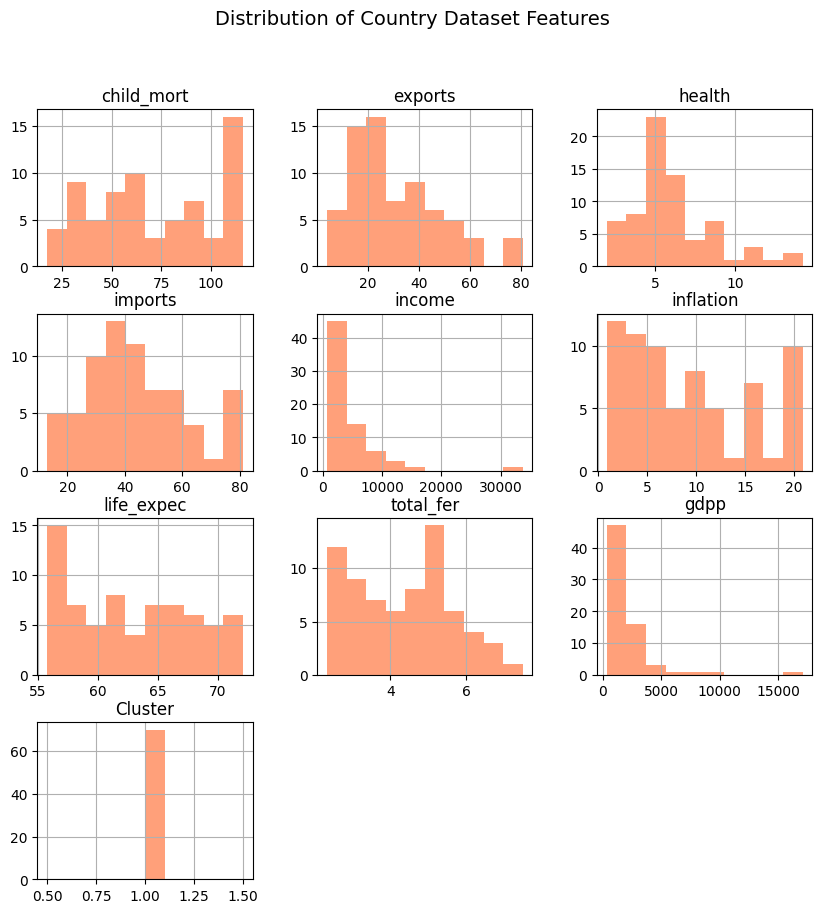

In [88]:
# Histogram of the dataset
cluster_1_df.hist(bins=10, color='#FFA07A', figsize=(10,10))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

Hierartical Cluster of Cluster 1

In [93]:
# standardising the data
features1 = cluster_1_df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
data_norm = normalize(features1)
data_norm = pd.DataFrame(data_norm, columns=features1.columns)
data_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.052863,0.005861,0.004442,0.026314,0.943556,0.005532,0.032937,0.003411,0.324091
1,0.016868,0.009059,0.000414,0.006238,0.857923,0.003035,0.008739,0.000896,0.513300
2,0.019322,0.006258,0.001377,0.008527,0.954381,0.002793,0.027536,0.000911,0.296484
3,0.056170,0.012044,0.002075,0.018825,0.920991,0.000448,0.031273,0.002712,0.383577
4,0.006297,0.006267,0.000767,0.010426,0.946755,0.000883,0.010633,0.000351,0.321484


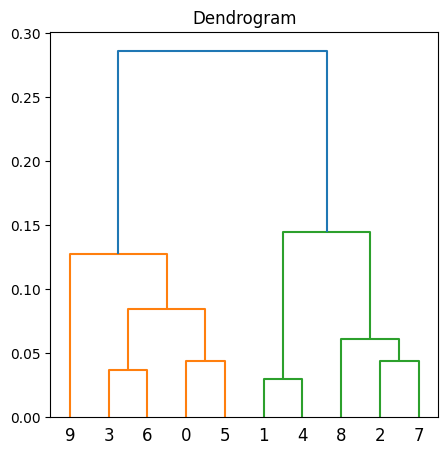

In [125]:
# dendrogram to find the number of clusters
subset_data = data_norm.sample(n=10)

plt.figure(figsize=(5,5))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(subset_data, method='ward'))
plt.show()

In [127]:
# Using sillhoute score to determine the k value

sil_score = []
k_range = range(2, 11)

for k in k_range:
    cluster = AgglomerativeClustering(n_clusters=k, metric= 'euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(data_norm)


    score = silhouette_score(data_norm, cluster_labels)
    sil_score.append(score)
    print(f'Sillohte score for k={k}: {score}')

Sillohte score for k=2: 0.5910762541502208
Sillohte score for k=3: 0.5493874965528686
Sillohte score for k=4: 0.40505982384446515
Sillohte score for k=5: 0.4066161217082721
Sillohte score for k=6: 0.4332184222592003
Sillohte score for k=7: 0.38173035611739714
Sillohte score for k=8: 0.3604471158802795
Sillohte score for k=9: 0.37692356956774165
Sillohte score for k=10: 0.3721086509222273


In [128]:
# dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_norm)

In [129]:
# agglomerative clustering
clus = AgglomerativeClustering(n_clusters=2, metric= 'euclidean', linkage='ward')
now = clus.fit_predict(reduced_data)

In [131]:
now

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1])

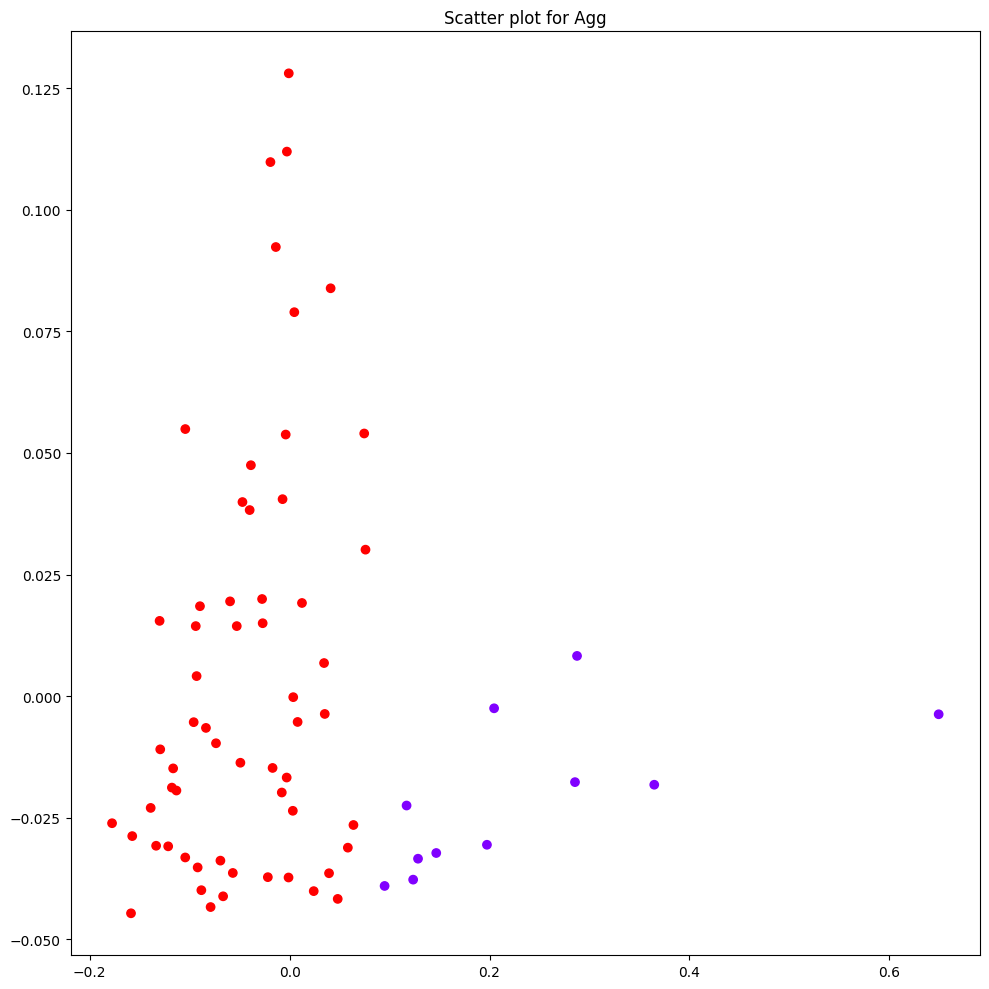

In [132]:
plt.figure(figsize=(10,10))
plt.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], c=now, cmap='rainbow')
plt.title('Scatter plot for Agg')
plt.tight_layout()
plt.show()